# Personalized Movie Recommendation System

**Author:** Shadin Chatila

**Date:** 1/24/2025

---

Load the datasets and import packages

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse


# Load the datasets
movies = pd.read_csv('/Users/shadinchatila/Downloads/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/shadinchatila/Downloads/ml-latest-small/ratings.csv')


In [22]:
# Check for empty genres
print("Number of movies with blank genres:", movies[movies['genres'] == ''].shape[0])

# Replace blank genres with 'Unknown'
movies['genres'] = movies['genres'].replace('', 'Unknown')


Number of movies with blank genres: 0


## EDA (Exploratory Data Analysis)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


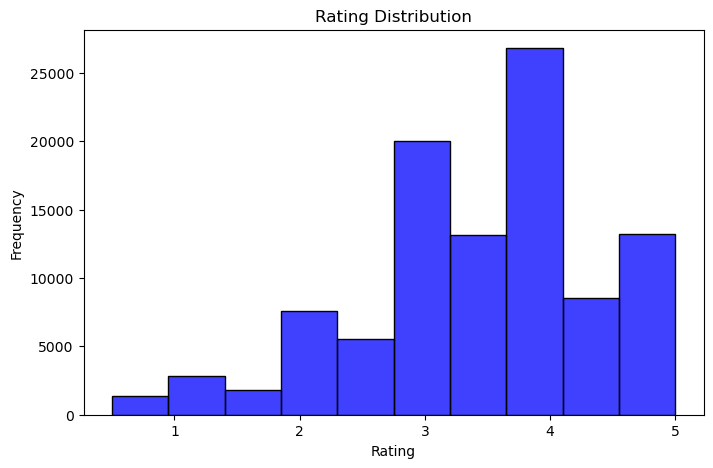

In [23]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=10, kde=False, color='blue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


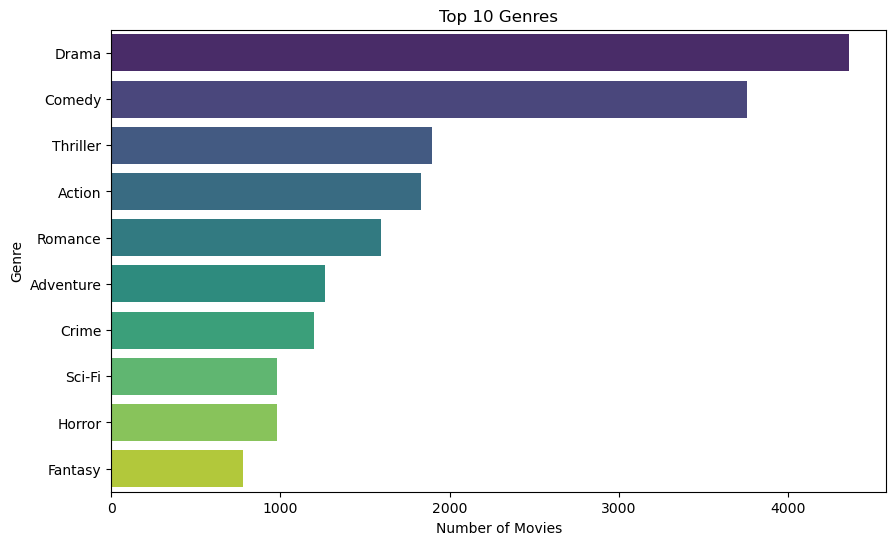

In [24]:
# Split and count genres
genres_split = movies['genres'].str.split('|').explode()
top_genres = genres_split.value_counts().reset_index()
top_genres.columns = ['Genre', 'Count']

# Plot top genres
plt.figure(figsize=(10, 6))
sns.barplot(data=top_genres.head(10), x='Count', y='Genre', palette='viridis')
plt.title('Top 10 Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


In [25]:
# Count ratings for each movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count().reset_index()
movie_ratings_count.columns = ['movieId', 'rating_count']

# Merge with movies
top_rated_movies = movie_ratings_count.merge(movies, on='movieId')
top_rated_movies = top_rated_movies.sort_values('rating_count', ascending=False).head(10)

print("Top 10 Most Rated Movies:")
print(top_rated_movies[['title', 'rating_count']])


Top 10 Most Rated Movies:
                                          title  rating_count
314                         Forrest Gump (1994)           329
277            Shawshank Redemption, The (1994)           317
257                         Pulp Fiction (1994)           307
510            Silence of the Lambs, The (1991)           279
1938                         Matrix, The (1999)           278
224   Star Wars: Episode IV - A New Hope (1977)           251
418                        Jurassic Park (1993)           238
97                            Braveheart (1995)           237
507           Terminator 2: Judgment Day (1991)           224
461                     Schindler's List (1993)           220


## Content Based Reccomendation System

Create the User Item matrix

In [39]:
# Pivot ratings into a user-item matrix
userItem_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Normalize the user-item matrix by subtracting the mean user ratings
user_mean = userItem_matrix.mean(axis=1)
normalized_matrix = userItem_matrix.sub(user_mean, axis=0).fillna(0)

# Convert normalized data to sparse format and calculate similarity
sparse_matrix = csr_matrix(normalized_matrix)
similarity_matrix = cosine_similarity(sparse_matrix.T)


Mapping the movie titles to movie IDs

In [41]:
# Creates a mapping between the movie titles and movie IDs
movie_title_to_id = dict(zip(movies['title'], movies['movieId']))
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))

Creating a reccomender function

In [42]:

# This function takes in a movie title and returns a list of similar movie recommendations
def recommend_movies(movie_title, num_of_recs=10):
    movie_id = movie_title_to_id.get(movie_title)
    if movie_id is None:
        return f"Movie '{movie_title}' is not found in the dataset."
    
    # Find the index of the movie in the matrix
    movie_idx = userItem_matrix.columns.get_loc(movie_id)

    # Retrieve similarity scores
    similarity_scores = list(enumerate(similarity_matrix[movie_idx]))

    # Sort by similarity score
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get top recommendations
    top_movies = [movie_id_to_title[userItem_matrix.columns[i]] for i, _ in sorted_scores[1:num_of_recs+1]]
    return top_movies

# Test the function
print("Recommendations for 'Jurassic Park (1993)':")
print(recommend_movies("Jurassic Park (1993)", 10))


Recommendations for 'Jurassic Park (1993)':
['Terminator 2: Judgment Day (1991)', 'Forrest Gump (1994)', 'Braveheart (1995)', 'Fugitive, The (1993)', 'Speed (1994)', 'Batman (1989)', 'Independence Day (a.k.a. ID4) (1996)', 'Apollo 13 (1995)', 'True Lies (1994)', 'Lion King, The (1994)']


In [44]:
# Fallback: Recommend top-rated movies
def fallback_recommendations(num_of_recs=10):
    # Compute average ratings for each movie
    top_rated = ratings.groupby('movieId')['rating'].mean().reset_index()
    top_rated = top_rated.merge(movies, on='movieId').sort_values('rating', ascending=False)
    return top_rated['title'].head(num_of_recs).tolist()

# Test the fallback function
print("Fallback Recommendations:")
print(fallback_recommendations())


Fallback Recommendations:
['Paper Birds (Pájaros de papel) (2010)', 'Act of Killing, The (2012)', 'Jump In! (2007)', 'Human (2015)', 'L.A. Slasher (2015)', 'Lady Jane (1986)', 'Bill Hicks: Revelations (1993)', 'Justice League: Doom (2012) ', 'Open Hearts (Elsker dig for evigt) (2002)', 'Formula of Love (1984)']


In [45]:
# Test content-based recommendation system
print("Recommendations for 'Jurassic Park (1993)':")
print(recommend_movies("Jurassic Park (1993)", 10))


Recommendations for 'Jurassic Park (1993)':
['Terminator 2: Judgment Day (1991)', 'Forrest Gump (1994)', 'Braveheart (1995)', 'Fugitive, The (1993)', 'Speed (1994)', 'Batman (1989)', 'Independence Day (a.k.a. ID4) (1996)', 'Apollo 13 (1995)', 'True Lies (1994)', 'Lion King, The (1994)']


In [43]:
# Load data into Surprise format
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Use Singular Value Decomposition (SVD)
svd = SVD()
svd.fit(trainset)

# Predict ratings
predictions = svd.test(testset)

# Evaluate model performance
print("RMSE of collaborative filtering:", rmse(predictions))

RMSE: 0.8773
RMSE of collaborative filtering: 0.8772834878149185


In [47]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Load the dataset in Surprise's format
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train SVD model
svd = SVD()
svd.fit(trainset)

# Test the model on the testset and evaluate
predictions = svd.test(testset)
print("RMSE of SVD model:", rmse(predictions))

# Collaborative filtering recommendation function
def recommend_movies_svd(user_id, num_of_recs=10):
    all_movie_ids = ratings['movieId'].unique()
    predictions = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in all_movie_ids]
    top_movies = sorted(predictions, key=lambda x: x[1], reverse=True)[:num_of_recs]
    return [movie_id_to_title[movie_id] for movie_id, _ in top_movies]

# Test the SVD recommender
print("Collaborative Filtering Recommendations for User 1:")
print(recommend_movies_svd(1, 10))


RMSE: 0.8741
RMSE of SVD model: 0.8741388881784138
Collaborative Filtering Recommendations for User 1:
['Star Wars: Episode IV - A New Hope (1977)', 'Fargo (1996)', 'Princess Bride, The (1987)', 'Back to the Future (1985)', 'Shawshank Redemption, The (1994)', 'Departed, The (2006)', "Singin' in the Rain (1952)", 'Rear Window (1954)', 'North by Northwest (1959)', 'Casablanca (1942)']


Test the function using sample

In [48]:
from surprise.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_factors': [50, 100, 150],  # Number of latent factors
    'n_epochs': [20, 50, 100],    # Number of training epochs
    'lr_all': [0.002, 0.005],     # Learning rate
    'reg_all': [0.02, 0.1]        # Regularization term
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Get best parameters and RMSE
print("Best RMSE:", gs.best_score['rmse'])
print("Best Parameters:", gs.best_params['rmse'])

# Use the best parameters to train the SVD model
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)


Best RMSE: 0.8582627018113088
Best Parameters: {'n_factors': 150, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}
